In [1]:
import torch
from PIL import Image
from torchvision import transforms
import json
import urllib
from copy import deepcopy
import torch.nn as nn
from torch.optim import Adam
from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
import numpy as np
from typing import Callable, Union, Optional
from functools import partial

# Loading Alexnet Model

In [2]:
alexnet = torch.hub.load(
    'pytorch/vision:v0.6.0', 'alexnet', 
    pretrained=True) # loading alexnet model

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


# Loading list of Imagenet classes

In [3]:
# downloading ImageNet class names
imagenet_class_filename = "ImageNet.json"
urllib.request.urlretrieve(
     "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json", 
     imagenet_class_filename)

# loading class names
with open(imagenet_class_filename) as f:
  imagenet_classes = json.load(f)

imagenet_classes = [v[1] for _, v in imagenet_classes.items()]

In [4]:
print(f"Got {len(imagenet_classes)} imagenet classes.")
imagenet_classes[:5]

Got 1000 imagenet classes.


['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']

# Sufficient transformations to prepare image for model

In [5]:
trfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Original image shape: torch.Size([1213, 1546, 3])


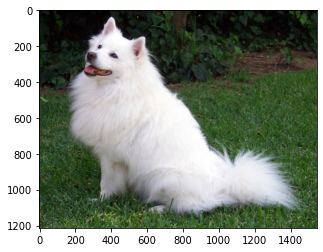

In [6]:
img_url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
img_name = "dog.jpg"
urllib.request.urlretrieve(img_url, img_name)
img = Image.open(img_name)
print(f"Original image shape: {torch.tensor(np.array(img)).shape}")
plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Transformed image shape: torch.Size([3, 224, 224])


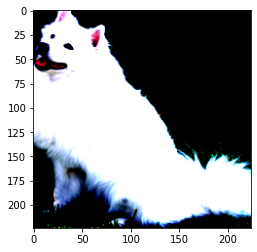

In [7]:
img_tensor = trfms(img)
print(f"Transformed image shape: {img_tensor.shape}")
plt.imshow(img_tensor.permute(1,2,0))
plt.show()

In [8]:
def predict(output: torch.tensor):
  return torch.argmax(nn.Softmax(dim=1)(output), dim=1) 

In [9]:
input = img_tensor.unsqueeze(0) # make batch of size 1
alexnet.eval()
print(f"Model prediction of input image: {imagenet_classes[predict(alexnet(input))]}")

Model prediction of input image: Samoyed


In [10]:
# storing original model params for safety
original_model_params = deepcopy(alexnet.state_dict())

In [11]:
def target_attack(
    model: nn.Module,
    input: torch.tensor,
    target: torch.tensor,
    norm: Union[int, float]=None,
    norm_weight: float=1e-4,
    fast_gradient: bool=False,
    epochs: int=100, 
    lr: float=1e-3, 
    eps: Union[None, float]=None, 
    track_loss: bool=False) -> torch.tensor:
  
  device = ("cuda" if torch.cuda.is_available() else "cpu")
  # device="cpu"
 
  model = model.to(device)
  input = input.to(device)
  target = target.to(device)

  # initiate perturbation
  perturbation = torch.randn(
      size=input.shape, 
      dtype=torch.float32,
      requires_grad=True, 
      device=device)
  
  if eps is not None:
      perturbation.data = torch.clamp(perturbation.data, -eps, eps)

  perturbation.retain_grad()

  adam = Adam([perturbation], lr=lr)
  
  def crossEntropyLoss(model, input, perturbation, target):
    return nn.CrossEntropyLoss()(
              model(input + perturbation), target)
  
  def normLoss(norm, model, input, perturbation, target):
    return norm_weight * torch.linalg.norm(
        perturbation, ord=norm, dim=1).sum() + crossEntropyLoss(
            model, input, perturbation, target) 
        
  if norm is None:
    loss = crossEntropyLoss
  else:
    loss = partial(normLoss, norm=norm)

  t = tqdm(range(epochs))
  losses = []
  for i in t:
    loss_ = loss(
        model=model, 
        input=input, 
        perturbation=perturbation,
        target=target)
    if track_loss:
      losses.append(loss_.data)
    if (i+1)%10==0: t.set_description(f"i: {i+1}, loss: {loss_.data:.4f}")
  
    if (fast_gradient and perturbation.grad is not None):
      perturbation.grad.data.zero_()
    else:
      adam.zero_grad()

    loss_.backward()
  
    if fast_gradient:
      perturbation.data -= lr * torch.sign(perturbation.grad.data)
    else:
      adam.step()
      # perturbation.data -= lr * perturbation.grad.data

    if eps is not None:
      perturbation.data = torch.clamp(perturbation.data, -eps, eps)

  return perturbation.data.cpu(), losses

In [12]:
misclassified_target_idx = 20
print(f"Targeted misclassified class: {imagenet_classes[misclassified_target_idx]}")
misclassified_target_label = torch.tensor([misclassified_target_idx], dtype=torch.long)

Targeted misclassified class: water_ouzel


In [13]:
# perturbation, losses = target_attack(
#     model=alexnet,
#     input=input, 
#     target=misclassified_target_label, 
#     norm=2,
#     norm_weight=1e-2,
#     fast_gradient=False,
#     track_loss=True,
#     lr=1e-3,
#     epochs=2000,
#     eps=32./255,)


# perturbation, losses = target_attack(
#     model=alexnet,
#     input=input, 
#     target=misclassified_target_label, 
#     # norm=2,
#     # norm_weight=1e-2,
#     fast_gradient=True,
#     track_loss=True,
#     lr=1e-3,
#     epochs=2000,
#     eps=32./255,) 


# perturbation, losses = target_attack(
#     model=alexnet,
#     input=input, 
#     target=misclassified_target_label, 
#     norm=float("inf"),
#     norm_weight=1e-2,
#     fast_gradient=False,
#     track_loss=True,
#     lr=1e-3,
#     epochs=2000,
#     eps=32./255,) 

perturbation, losses = target_attack(
    model=alexnet,
    input=input, 
    target=misclassified_target_label, 
    norm=1,
    norm_weight=1e-3,
    fast_gradient=False,
    track_loss=True,
    lr=1e-3,
    epochs=2000,
    eps=32./255,) 

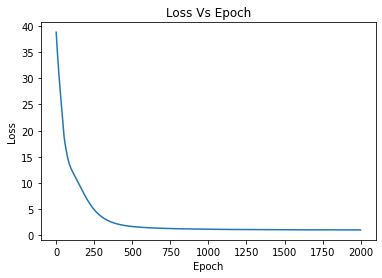

In [14]:
plt.plot(losses)
plt.title("Loss Vs Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


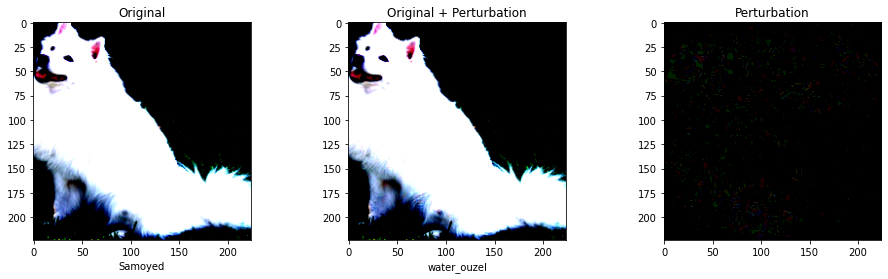

In [15]:
alexnet = alexnet.to("cpu")
alexnet.eval()
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 4))
ax1.imshow((input)[0].permute(1,2,0))
ax1.set_title("Original")
ax1.set_xlabel(imagenet_classes[predict(alexnet(input))])
ax2.imshow((input+perturbation)[0].permute(1,2,0))
ax2.set_title("Original + Perturbation")
ax2.set_xlabel(imagenet_classes[predict(alexnet(input + perturbation))])
ax3.imshow((perturbation)[0].permute(1,2,0))
ax3.set_title("Perturbation")
plt.show()

In [16]:
alexnet = alexnet.to("cpu")
alexnet.eval()
imagenet_classes[predict(alexnet(input+perturbation))]

'water_ouzel'

In [17]:
def loss(a):
  return torch.sum(a**2)

In [18]:
a = torch.randn((2,3), requires_grad=True)
a.retain_grad()
print(a)
# adam = Adam(nn.ParameterList([nn.Parameter(a)]))
adam = Adam([a])
loss_ = loss(a)
adam.zero_grad()
loss_.backward()
print(a)
adam.step()
print(a)

tensor([[ 0.5430, -0.8333,  0.9264],
        [ 0.8897, -1.5768, -0.1634]], requires_grad=True)
tensor([[ 0.5430, -0.8333,  0.9264],
        [ 0.8897, -1.5768, -0.1634]], requires_grad=True)
tensor([[ 0.5420, -0.8323,  0.9254],
        [ 0.8887, -1.5758, -0.1624]], requires_grad=True)


In [19]:
a = torch.randn((2,3))
print(a, "\n", torch.sign(a))

tensor([[-0.2308,  1.0561,  1.0983],
        [ 1.2660, -0.1319,  1.8742]]) 
 tensor([[-1.,  1.,  1.],
        [ 1., -1.,  1.]])


In [20]:
a = torch.randn((2,3))
assert torch.allclose(torch.sqrt((a**2).sum()), torch.linalg.norm(a))

In [21]:
a = torch.randn((1,2,2,3))
torch.linalg.norm(a, ord=float('inf'))

RuntimeError: ignored

In [ ]:
torch.linalg.norm(torch.tensor([1.0, 2.0]),ord=1)

In [ ]:
torch.linalg.norm(a, ord=float('inf'), dim=1)

In [ ]:
torch.linalg.norm(a, ord=float('inf'), dim=1).sum()